## Purpose

This script is testing out the pyspatial library as a tool to create a random forest model on raster data and use that model to predict. 

## Read in raster and calculate spectral indices

1. Read in and rename raw raster using pyspatialml Raster function
2. Calculate spectral indicies
3. Use stack function to create new raster of indices

In [1]:
from pyspatialml import Raster

raw_fp = "data_raw/" # file path to raw data folder
raster_fp = raw_fp + 'white_small_sub.tif' # combine with tif file
stack_raw = Raster(raster_fp)
stack_raw.names
stack_raw.rename({'white_small_sub_1': 'coastal'})
stack_raw.rename({'white_small_sub_2': 'blue'})
stack_raw.rename({'white_small_sub_3': 'green'})
stack_raw.rename({'white_small_sub_4': 'yellow'})
stack_raw.rename({'white_small_sub_5': 'red'})
stack_raw.rename({'white_small_sub_6': 'rededge'})
stack_raw.rename({'white_small_sub_7': 'NIR1'})
stack_raw.rename({'white_small_sub_8': 'NIR2'})

In [2]:
# Define nre_func
def nre_fun(x, y):
    nre = (x - y) / (x + y)
    return nre


In [3]:
# Warning takes ~10 min to calc all indicies below
green_red = nre_fun(stack_raw['green'], stack_raw['red'])
blue_coastal = nre_fun(stack_raw['blue'], stack_raw['coastal'])
NIR2_yellow = nre_fun(stack_raw['NIR2'], stack_raw['yellow'])
NIR1_red = nre_fun(stack_raw['NIR1'], stack_raw['red'])
rededge_yellow = nre_fun(stack_raw['rededge'], stack_raw['yellow'])
red_NIR2 = nre_fun(stack_raw['red'], stack_raw['NIR2'])
rededge_NIR2 = nre_fun(stack_raw['rededge'], stack_raw['NIR2'])
rededge_NIR1 = nre_fun(stack_raw['rededge'], stack_raw['NIR1'])
green_NIR1 = nre_fun(stack_raw['green'], stack_raw['NIR1'])
green_NIR2 = nre_fun(stack_raw['green'], stack_raw['NIR2'])
rededge_green = nre_fun(stack_raw['rededge'], stack_raw['green'])
rededge_red = nre_fun(stack_raw['rededge'], stack_raw['red'])
yellow_NIR1 = nre_fun(stack_raw['yellow'], stack_raw['NIR1'])
NIR2_blue = nre_fun(stack_raw['NIR2'], stack_raw['blue'])
blue_red = nre_fun(stack_raw['blue'], stack_raw['red'])

# Make list of all indicies
predictors = [green_red, blue_coastal, NIR2_yellow, NIR1_red,
              rededge_yellow, red_NIR2, rededge_NIR2,
              rededge_NIR1, green_NIR1, green_NIR2, rededge_green,
              rededge_red, yellow_NIR1, NIR2_blue, blue_red]

# Stack indicies in new raster
stack = Raster(predictors)

# Rename each raster in stack
feature_names_orig = stack.names

feature_names = ['green red', 'blue coastal', 'NIR2 yellow', 'NIR1 red',
              'rededge yellow', 'red NIR2', 'rededge NIR2', 'rededge NIR1',
              'green NIR1', 'green NIR2', 'rededge green', 'rededge red',
              'yellow NIR1', 'NIR2 blue', 'blue red']


for n in range(len(feature_names_orig)):
    stack.rename({feature_names_orig[n]:feature_names[n]})

Save indices - checkpoint to save a few minutes of processing time. Don't need to run this but it saves some time for testing.

In [4]:

# indx_tif = 'indx.tif'
# newstack = stack.write(file_path=indx_tif, nodata=-9999)

## Stratified random sampling

Here is an example using `sample` with a categorical raster overlaid. The `extract_vector` tool was taking a long time so this is a different approach. 

The strata raster used here was created from the shapefile `Lindsay_white_river_landcover` using the info (extent, cell size, projection) from `white_small_sub.tif`. The strata raster was created in ArcGIS using the `Polygon to Raster` tool. Maybe a programatic way to do it using `fiona`? Untested, but a little Googling says this should be possible.

### Import categorical raster


In [5]:
import rasterio

strata_dir = 'data_raw\Lindsay_white_river_land_cover\white_lc.tif'
strata_rast = rasterio.open(strata_dir)

### Stack categorical raster with existing raster stack of indices

I'm not positive we need this, but this way when we `sample` the raster we have the land cover class info with each point

https://pyspatialml.readthedocs.io/en/latest/sampling.html

In [6]:
# stack = rasterio.open('indx.tif') # use this line if using the checkpoint tif
stack_w_cat = stack.append(Raster(strata_rast), in_place = False)

stack_w_cat.count # should be 16, 15 indices + 1 categorical layer

16

### Sample the raster

Here the input raster is 16 layers, 15 indices and the land cover classes. One test run took 13 min to randomly sample 10000 pts from each category. Seems much faster than `extract_vector`.

In [7]:
with rasterio.open(strata_dir) as strata:
    df_strata = stack_w_cat.sample(size=10000, strata=strata, random_state=1)
    df_strata = df_strata.dropna() # some points have NA in a couple indices. Why?

    # Fix column names
    df_strata = df_strata.rename(columns=dict(zip(df_strata.drop('geometry', axis = 1).columns, feature_names + ['class'])))

## Random forest model

### Partition data into testing and training data

In [8]:
from sklearn.model_selection import train_test_split

labels = df_strata['class']

X_train, X_test, y_train, y_test = train_test_split(df_strata[feature_names],
                                                    labels, 
                                                    train_size = 0.9,
                                                    random_state = 42,
                                                    stratify = labels)

### Train model

In [9]:
# Train model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 200,
                            max_features = 5,
                            random_state = 8)

rf.fit(X_train, y_train)

RandomForestClassifier(max_features=5, n_estimators=200, random_state=8)

In [10]:
# save it to checkpoint work
import pickle

with open('white_river_rf.pkl', 'wb') as f:
    pickle.dump(rf, f)  

### Check model performance

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_train, y_train, random_state = 8)
predictions = rf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

accuracy

0.7736659169903906

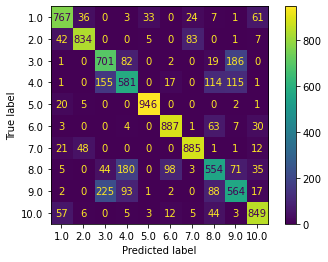

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pandas as pd

confmat = confusion_matrix(y_test, predictions)
df_confmat = pd.DataFrame(confmat)
plot_confusion_matrix(rf, X_test, y_test)

## Use RF model to predict raster stack

Use `pyspatialml.predict` on raster stack of spectral indices from `white_small_sub.tif` 

In [13]:
# stack = rasterio.open('indx.tif') # use this line if using the checkpoint tif

result = stack.predict(estimator=rf, dtype = 'int16', nodata=0)

In [14]:
# save result
result.write(file_path='predictions.tif', nodata=-9999)

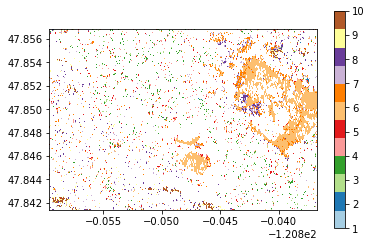

In [15]:
# plot classification result
import matplotlib.pyplot as plt

result.iloc[0].cmap = "Paired"
result.iloc[0].categorical = True
result.plot()
plt.show()

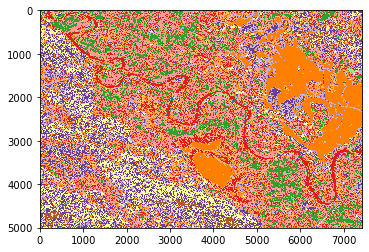

In [16]:
# set RasterLayer color table
from rasterio.plot import show

show(result.read(), cmap='Paired')
